In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statistics import mean
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from datetime import datetime, timedelta
%matplotlib inline

### Read Data

In [3]:
products = pd.read_excel("dunnhumby - Breakfast at the Frat.xlsx", sheet_name='dh Products Lookup', header=1)
products = products.iloc[0:58, 0:6]
products.UPC = products.UPC.astype(int)
products.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111035398,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),1.5 LT
4,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [4]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   UPC           58 non-null     int64 
 1   DESCRIPTION   58 non-null     object
 2   MANUFACTURER  58 non-null     object
 3   CATEGORY      58 non-null     object
 4   SUB_CATEGORY  58 non-null     object
 5   PRODUCT_SIZE  58 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.8+ KB


In [5]:
store = pd.read_excel("dunnhumby - Breakfast at the Frat.xlsx", sheet_name='dh Store Lookup', header=1)
store = store.iloc[:,0:9]
store.drop_duplicates(subset ="STORE_ID", keep = "first", inplace = True)
store.head()

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24766.807692
1,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54052.519231
2,4259,WARSAW AVENUE,CINCINNATI,OH,17140,VALUE,NaN,48813,31177.333333
3,6379,KINGWOOD,KINGWOOD,TX,26420,MAINSTREAM,NaN,50237,20620.423077
4,6431,AT WARD ROAD,BAYTOWN,TX,26420,VALUE,350.0,43698,24321.942308


In [6]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 78
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   STORE_ID                 77 non-null     int64  
 1   STORE_NAME               77 non-null     object 
 2   ADDRESS_CITY_NAME        77 non-null     object 
 3   ADDRESS_STATE_PROV_CODE  77 non-null     object 
 4   MSA_CODE                 77 non-null     int64  
 5   SEG_VALUE_NAME           77 non-null     object 
 6   PARKING_SPACE_QTY        26 non-null     float64
 7   SALES_AREA_SIZE_NUM      77 non-null     int64  
 8   AVG_WEEKLY_BASKETS       77 non-null     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 6.0+ KB


In [7]:
trans_cereal = pd.read_csv("transaction_cereal.csv", index_col = 0)
trans_cereal

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY
6,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,0.0,0.0
7,2009-01-14,367.0,1111085345,29.0,26.0,25.0,54.52,1.88,1.88,0.0,0.0,0.0
8,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,0.0,0.0,0.0
12,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,0.0,0.0,0.0
13,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
524931,2012-01-04,29159.0,3800031838,48.0,43.0,39.0,157.92,3.29,3.29,0.0,0.0,0.0
524932,2012-01-04,29159.0,3800039118,21.0,17.0,17.0,70.98,3.38,3.38,0.0,0.0,0.0
524947,2012-01-04,29159.0,88491201426,32.0,29.0,23.0,105.92,3.31,3.31,0.0,0.0,0.0
524948,2012-01-04,29159.0,88491201427,30.0,26.0,23.0,99.30,3.31,3.31,0.0,0.0,0.0


### Merge Data (keep only cereal)

In [8]:
cereal = trans_cereal.merge(products, on='UPC')
cereal = cereal.merge(store, left_on='STORE_NUM', right_on='STORE_ID')
cereal

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,...,PRODUCT_SIZE,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
1,2009-01-21,367.0,1111085319,12.0,12.0,12.0,22.68,1.89,1.89,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
2,2009-01-28,367.0,1111085319,18.0,17.0,16.0,33.66,1.87,1.87,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
3,2009-02-04,367.0,1111085319,13.0,13.0,13.0,24.44,1.88,1.88,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
4,2009-02-11,367.0,1111085319,16.0,16.0,16.0,29.92,1.87,1.87,0.0,...,12.25 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12706.532051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169684,2011-12-07,29159.0,88491212971,12.0,12.0,12.0,34.20,2.85,2.85,0.0,...,11 OZ,29159,CARROLLTON,CARROLLTON,TX,19100,MAINSTREAM,NaN,54927,25916.532051
169685,2011-12-14,29159.0,88491212971,14.0,14.0,14.0,39.90,2.85,2.85,0.0,...,11 OZ,29159,CARROLLTON,CARROLLTON,TX,19100,MAINSTREAM,NaN,54927,25916.532051
169686,2011-12-21,29159.0,88491212971,22.0,22.0,21.0,62.70,2.85,2.85,0.0,...,11 OZ,29159,CARROLLTON,CARROLLTON,TX,19100,MAINSTREAM,NaN,54927,25916.532051
169687,2011-12-28,29159.0,88491212971,17.0,16.0,16.0,48.45,2.85,2.85,0.0,...,11 OZ,29159,CARROLLTON,CARROLLTON,TX,19100,MAINSTREAM,NaN,54927,25916.532051


In [22]:
cat = ["STORE_NUM", "UPC", "FEATURE", "DISPLAY", "TPR_ONLY", "MANUFACTURER", "CATEGORY", "SUB_CATEGORY", "STORE_ID", "STORE_NAME", "ADDRESS_CITY_NAME", "ADDRESS_STATE_PROV_CODE", "MSA_CODE", "SEG_VALUE_NAME"]
cereal[cat] = cereal[cat].astype("category")

In [18]:
# Create a dataframe for only cereal from Kellogg
# cereal_Kellogg = cereal[cereal.MANUFACTURER == "KELLOGG"]

---

### EDA_Product

In [23]:
## There are only three products from Kellogg cereal
cereal_Kellogg = pd.read_csv("cereal_Kellogg.csv", index_col = 0)
cat = ["STORE_NUM", "UPC", "FEATURE", "DISPLAY", "TPR_ONLY", "MANUFACTURER", "CATEGORY", "SUB_CATEGORY", "STORE_ID", "STORE_NAME", "ADDRESS_CITY_NAME", "ADDRESS_STATE_PROV_CODE", "MSA_CODE", "SEG_VALUE_NAME"]
cereal_Kellogg[cat] = cereal_Kellogg[cat].astype("category")
cereal_Kellogg['WEEK_END_DATE'] = pd.to_datetime(cereal_Kellogg['WEEK_END_DATE'])
cereal_Kellogg['MONTH'] = cereal_Kellogg['WEEK_END_DATE'].dt.month
cereal_Kellogg['YEAR'] = cereal_Kellogg['WEEK_END_DATE'].dt.year
cereal_Kellogg['MONTH'] = cereal_Kellogg['MONTH'].astype("category")
cereal_Kellogg['YEAR'] = cereal_Kellogg['YEAR'].astype("category")
cereal_Kellogg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35832 entries, 1331 to 169279
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WEEK_END_DATE            35832 non-null  datetime64[ns]
 1   STORE_NUM                35832 non-null  category      
 2   UPC                      35832 non-null  category      
 3   UNITS                    35832 non-null  float64       
 4   VISITS                   35832 non-null  float64       
 5   HHS                      35832 non-null  float64       
 6   SPEND                    35832 non-null  float64       
 7   PRICE                    35832 non-null  float64       
 8   BASE_PRICE               35830 non-null  float64       
 9   FEATURE                  35832 non-null  category      
 10  DISPLAY                  35832 non-null  category      
 11  TPR_ONLY                 35832 non-null  category      
 12  DESCRIPTION              358

In [24]:
## there are only 3 products
cereal_Kellogg.UPC.unique()

[3800031829, 3800031838, 3800039118]
Categories (3, int64): [3800031829, 3800031838, 3800039118]

In [25]:
cereal_Kellogg.DESCRIPTION.unique()

array(['KELL BITE SIZE MINI WHEAT', 'KELL FROSTED FLAKES',
       'KELL FROOT LOOPS'], dtype=object)

In [30]:
cereal_Kellogg.groupby('UPC')[['UNITS', 'BASE_PRICE', 'PRICE']].mean()

,UNITS,BASE_PRICE,PRICE
UPC,,,
3800031829,33.303007,3.273618,3.164362
3800031838,47.236561,3.044505,2.886601
3800039118,38.386257,3.144723,2.930515


### EDA_Store

In [33]:
## Counts by STORE_ID
cereal_Kellogg.STORE_ID.value_counts()

29159    468
21485    468
11967    468
11993    468
12011    468
        ... 
23061    465
23055    463
23327    463
8035     390
387      382
Name: STORE_ID, Length: 77, dtype: int64

In [34]:
## Counts by STORE_NAME
cereal_Kellogg.STORE_NAME.value_counts()

HOUSTON                 1867
MIDDLETOWN               936
PINEWOOD                 468
KINGWOOD                 468
KROGER JUNCTION S/C      468
                        ... 
NORWOOD                  465
LIBERTY TWP.             465
WALNUT HILLS/PEEBLES     463
OVER-THE-RHINE           390
TOWN & COUNTRY           382
Name: STORE_NAME, Length: 73, dtype: int64

In [47]:
## Counts by STATE
cereal_Kellogg.ADDRESS_STATE_PROV_CODE.value_counts()

TX    19169
OH    14326
KY     1869
IN      468
Name: ADDRESS_STATE_PROV_CODE, dtype: int64

<AxesSubplot:>

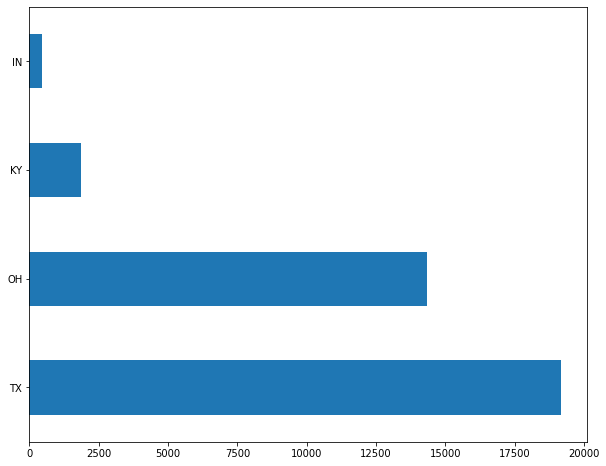

In [50]:
## Counts by STATE
plt.rcParams["figure.figsize"] = [10,8]
cereal_Kellogg.ADDRESS_STATE_PROV_CODE.value_counts().plot(kind='barh')

<AxesSubplot:>

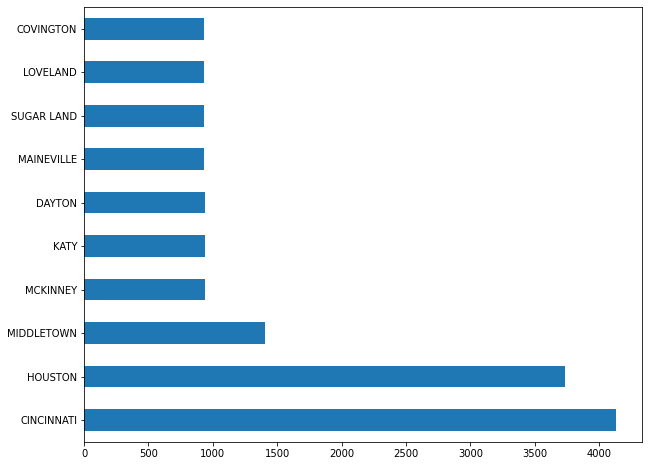

In [51]:
## Counts by CITY
cereal_Kellogg.ADDRESS_CITY_NAME.value_counts().head(10).plot(kind='barh')

In [85]:
## Kellogg Cereal UNITS by state & store
cereal_Kellogg_geo = cereal_Kellogg.groupby(["ADDRESS_STATE_PROV_CODE", "STORE_NAME"])["UNITS"].sum().to_frame(name="UNITS").reset_index()
cereal_Kellogg_geo[cereal_Kellogg_geo.UNITS != 0].sort_values("UNITS", ascending = False)

,ADDRESS_STATE_PROV_CODE,STORE_NAME,UNITS
245,TX,HOUSTON,72311.0
191,OH,MIDDLETOWN,46830.0
154,OH,CINCINNATI,45907.0
147,OH,ANDERSON TOWNE CTR,36760.0
159,OH,DAYTON,34566.0
...,...,...,...
273,TX,RICHARDSON,9456.0
213,OH,WALNUT HILLS/PEEBLES,8530.0
270,TX,PARKWAY SQUARE S/C,8208.0
196,OH,OVER-THE-RHINE,6877.0


In [86]:
## Kellogg Cereal UNITS by state
cereal_Kellogg.groupby(["ADDRESS_STATE_PROV_CODE"])["UNITS"].sum().to_frame(name='UNITS').reset_index()

,ADDRESS_STATE_PROV_CODE,UNITS
0,IN,20328.0
1,KY,88984.0
2,OH,668500.0
3,TX,643160.0


<AxesSubplot:>

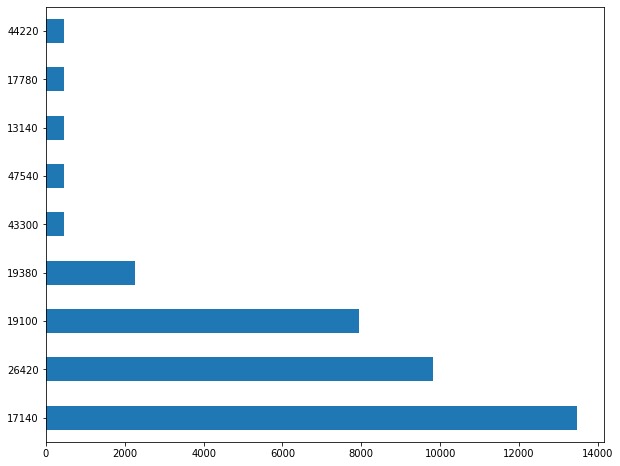

In [52]:
cereal_Kellogg.MSA_CODE.value_counts().plot(kind='barh')

<AxesSubplot:>

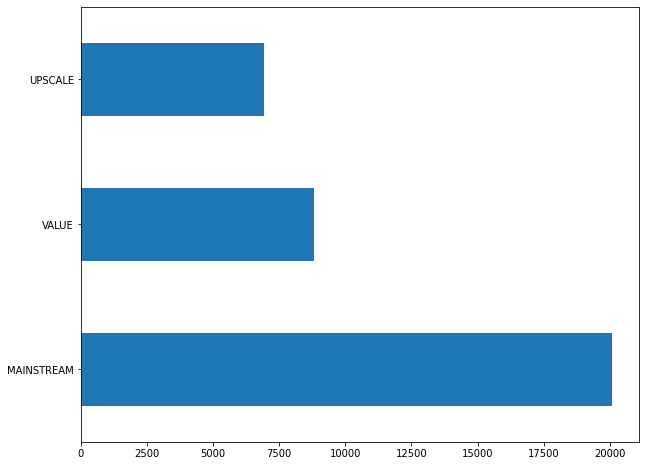

In [53]:
cereal_Kellogg.SEG_VALUE_NAME.value_counts().plot(kind='barh')

In [54]:
cereal_Kellogg[['PARKING_SPACE_QTY']].describe()

,PARKING_SPACE_QTY
count,11986.000000
mean,483.936676
std,404.376283
min,17.000000
25%,270.000000
50%,351.000000
75%,464.000000
max,1859.000000


In [55]:
cereal_Kellogg[['SALES_AREA_SIZE_NUM']].describe()

,SALES_AREA_SIZE_NUM
count,35832.000000
mean,49024.816142
std,13436.934048
min,10788.000000
25%,42437.000000
50%,48462.000000
75%,54448.000000
max,86517.000000


<AxesSubplot:>

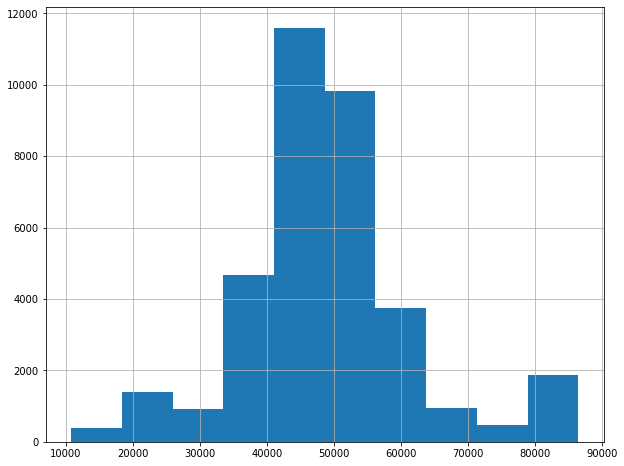

In [56]:
cereal_Kellogg.SALES_AREA_SIZE_NUM.hist()

In [57]:
cereal_Kellogg[['AVG_WEEKLY_BASKETS']].describe()

,AVG_WEEKLY_BASKETS
count,35832.000000
mean,24247.302480
std,8745.542387
min,10434.705128
25%,17009.897436
50%,24567.750000
75%,29386.416667
max,54052.519231


<AxesSubplot:>

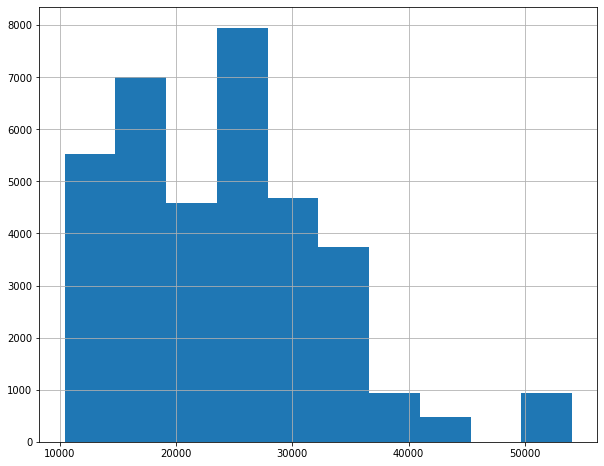

In [59]:
cereal_Kellogg.AVG_WEEKLY_BASKETS.hist()

<AxesSubplot:xlabel='SEG_VALUE_NAME', ylabel='SALES_AREA_SIZE_NUM'>

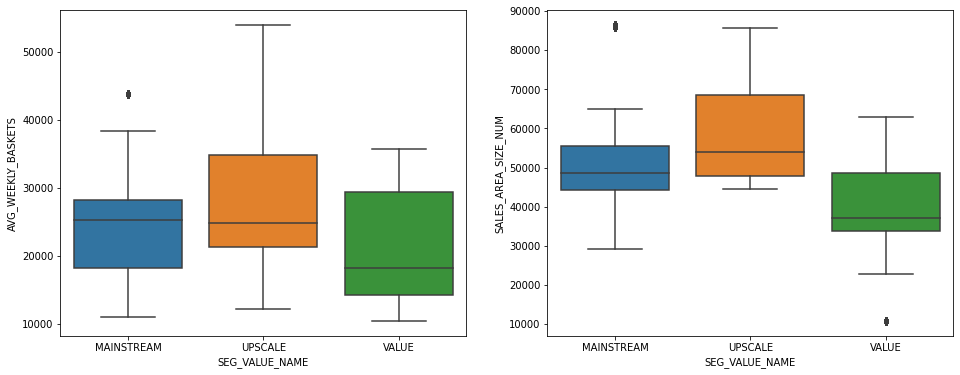

In [60]:
fig, axes=plt.subplots(1,2,figsize=(16,6))
sns.boxplot(x="SEG_VALUE_NAME", y="AVG_WEEKLY_BASKETS", data=cereal_Kellogg, ax=axes[0])
sns.boxplot(x="SEG_VALUE_NAME", y="SALES_AREA_SIZE_NUM", data=cereal_Kellogg, ax=axes[1])

### Transaction

<AxesSubplot:>

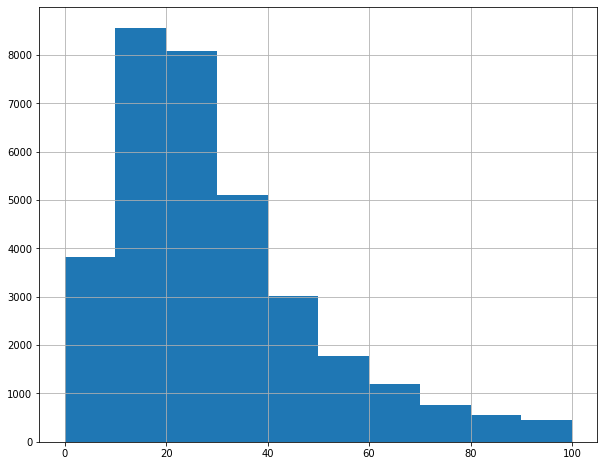

In [111]:
plt.rcParams["figure.figsize"] = [10,8]
cereal_Kellogg.UNITS.hist(range=(0,100))

<AxesSubplot:>

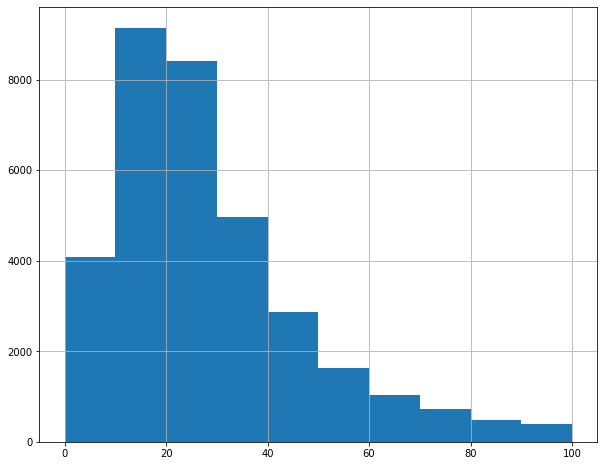

In [112]:
cereal_Kellogg.VISITS.hist(range=(0,100))

In [113]:
## units, visits and hhs have very high correlation
cereal_Kellogg[['UNITS','VISITS','HHS']].corr()

,UNITS,VISITS,HHS
UNITS,1.000000,0.992420,0.989704
VISITS,0.992420,1.000000,0.998354
HHS,0.989704,0.998354,1.000000


Examine 'UNITS/VISITS' metric. Identified extremely high ratio above 10.

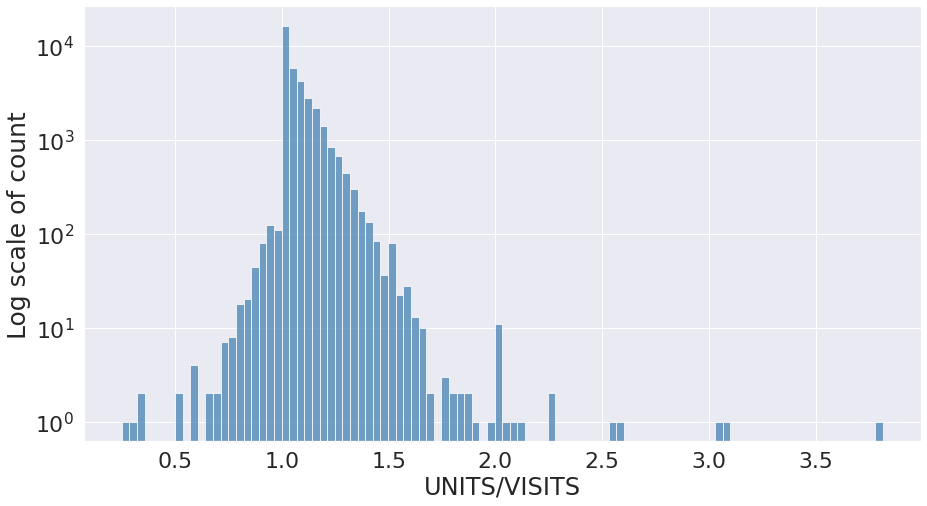

In [114]:
plt.rcParams["figure.figsize"] = [15,8]
cereal_Kellogg["UNITS/VISITS"] = cereal_Kellogg.UNITS / cereal_Kellogg.VISITS
sns.set(font_scale=2)
plt.ylabel("Log scale of count", size = 25)
plot = sns.histplot(x='UNITS/VISITS', data = cereal_Kellogg, bins = 100, color = "steelblue")
plot.set_yscale('log')

-----

Examine 'VISITS/HHS' metric. Identified extremely high ratio around 20.

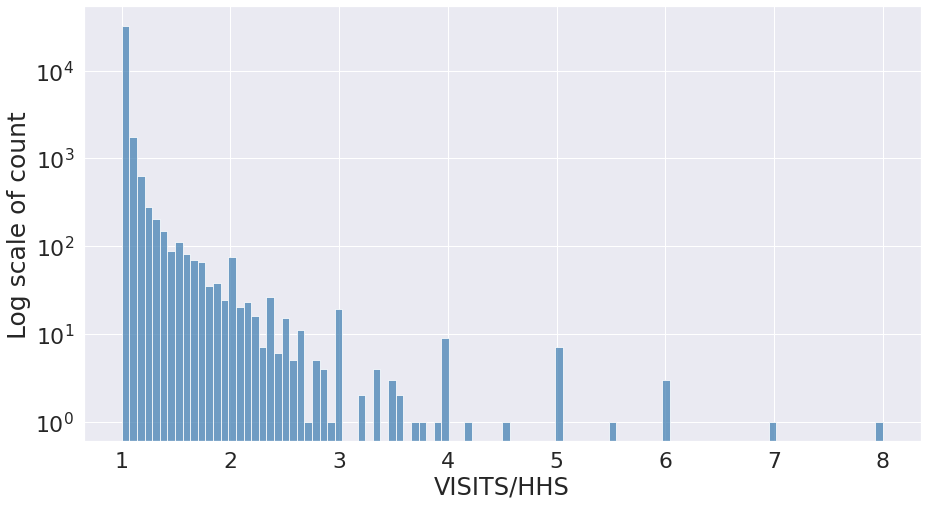

In [115]:
plt.rcParams["figure.figsize"] = [15,8]
cereal_Kellogg["VISITS/HHS"] = cereal_Kellogg.VISITS / cereal_Kellogg.HHS
sns.set(font_scale=2)
plt.ylabel("Log scale of count", size = 25)
plot = sns.histplot(x='VISITS/HHS', data = cereal_Kellogg, bins = 100, color = "steelblue")
plot.set_yscale('log')

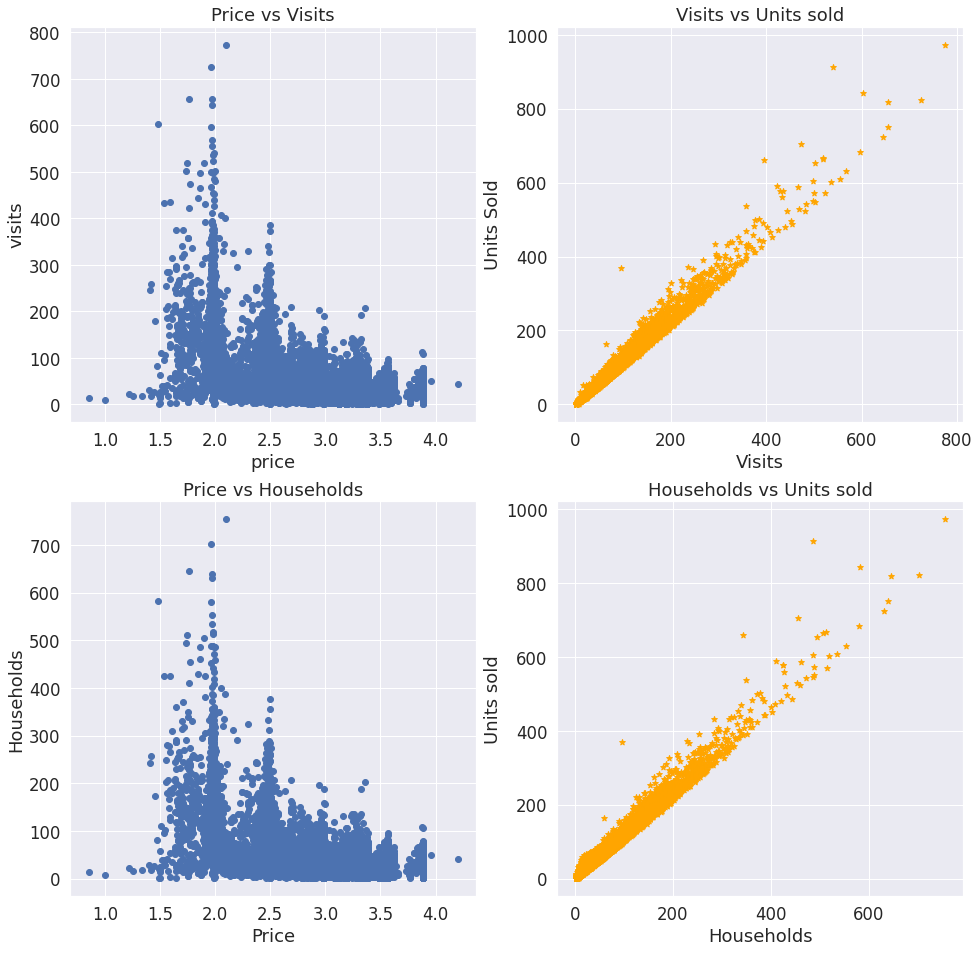

In [379]:
f, ax = plt.subplots(2,2,figsize=(16,16))
sns.set(font_scale=1.5)
# plt.xlim(1,2)
ax[0,0].scatter(cereal_Kellogg.PRICE, cereal_Kellogg.VISITS, marker='o')
ax[0,0].set_xlabel('price')
ax[0,0].set_ylabel('visits')
ax[0,0].set_title('Price vs Visits')

ax[0,1].scatter(cereal_Kellogg.VISITS, cereal_Kellogg.UNITS, marker='*', color = 'orange')
ax[0,1].set_xlabel('Visits')
ax[0,1].set_ylabel('Units Sold')
ax[0,1].set_title('Visits vs Units sold')

ax[1,0].scatter(cereal_Kellogg.PRICE, cereal_Kellogg.HHS, marker='o')
ax[1,0].set_xlabel('Price')
ax[1,0].set_ylabel('Households')
ax[1,0].set_title('Price vs Households')

ax[1,1].scatter(cereal_Kellogg.HHS, cereal_Kellogg.UNITS, marker='*', color = 'orange')
ax[1,1].set_xlabel('Households')
ax[1,1].set_ylabel('Units sold')
ax[1,1].set_title('Households vs Units sold')

plt.show()

Text(0.5, 1.0, 'Visits vs Households')

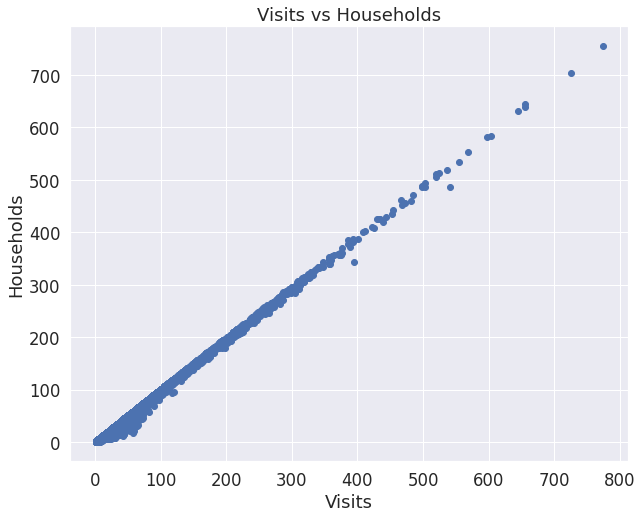

In [390]:
#f, ax = plt.subplots(2,2,figsize=(16,16))
sns.set(font_scale=1.5)
# plt.xlim(1,2)
plot = plt.scatter(cereal_Kellogg.VISITS, cereal_Kellogg.HHS, marker='o')
plt.xlabel('Visits')
plt.ylabel('Households')
plt.title('Visits vs Households')

In [372]:
cereal_Kellogg[['PRICE','UNITS', 'VISITS', 'HHS']].corr()

,PRICE,UNITS,VISITS,HHS
PRICE,1.000000,-0.555772,-0.555260,-0.563047
UNITS,-0.555772,1.000000,0.992420,0.989704
VISITS,-0.555260,0.992420,1.000000,0.998354
HHS,-0.563047,0.989704,0.998354,1.000000


In [105]:
sorted_date = cereal_Kellogg.WEEK_END_DATE.value_counts(sort=False).reset_index().sort_values('index').set_index('index')
sorted_date

,WEEK_END_DATE
index,
2009-01-14,230
2009-01-21,229
2009-01-28,230
2009-02-04,230
2009-02-11,227
...,...
2011-12-07,231
2011-12-14,231
2011-12-21,230


<AxesSubplot:xlabel='index'>

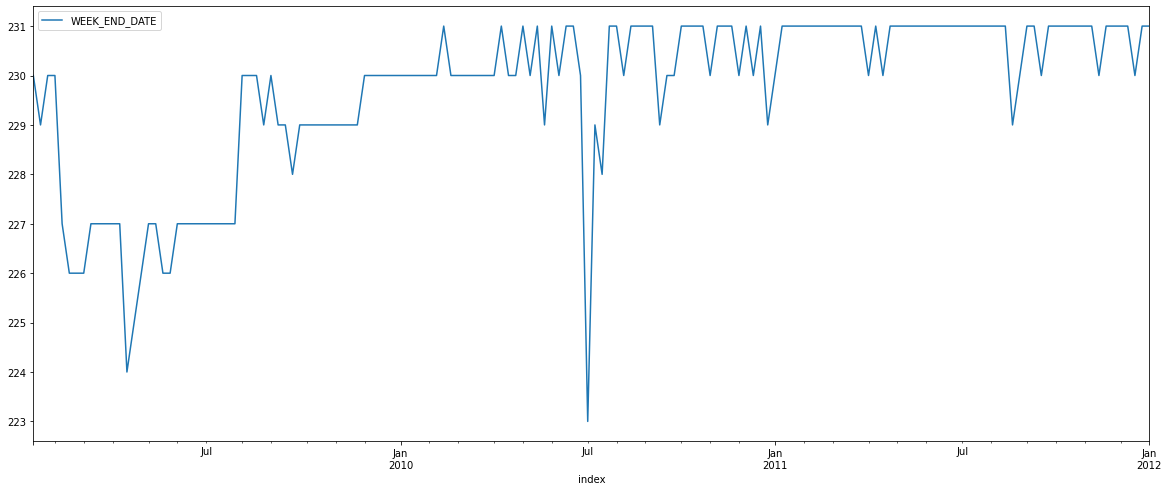

In [107]:
# number of transactions for Kellogg cereal
plt.rcParams["figure.figsize"] = [20,8]
sorted_date.plot()

Text(0.5, 0, 'Date')

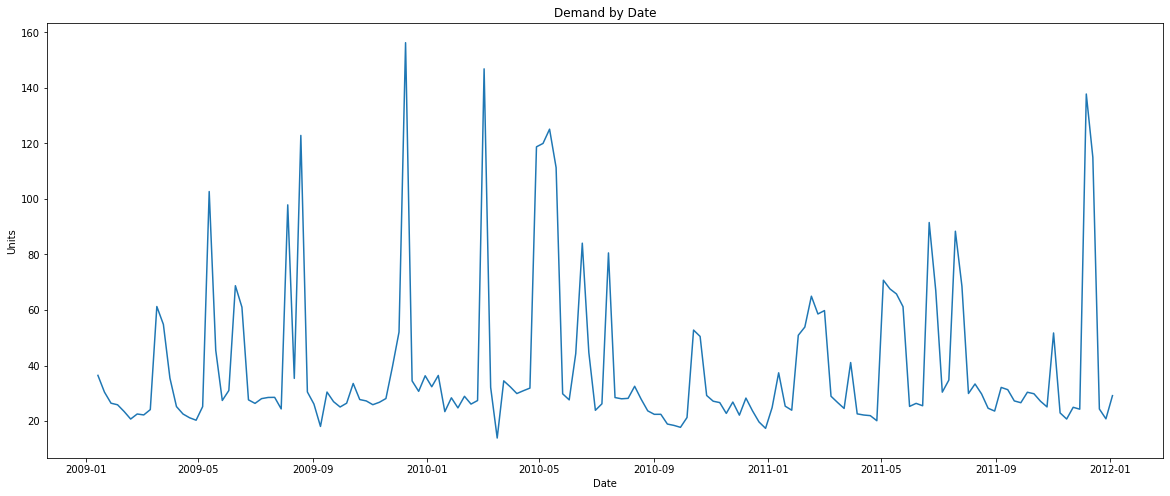

In [108]:
plt.rcParams["figure.figsize"] = [20,8]
plot_units = sns.lineplot(data=cereal_Kellogg, x="WEEK_END_DATE", y="UNITS", ci = None)
plt.title("Demand by Date")
plt.ylabel("Units")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

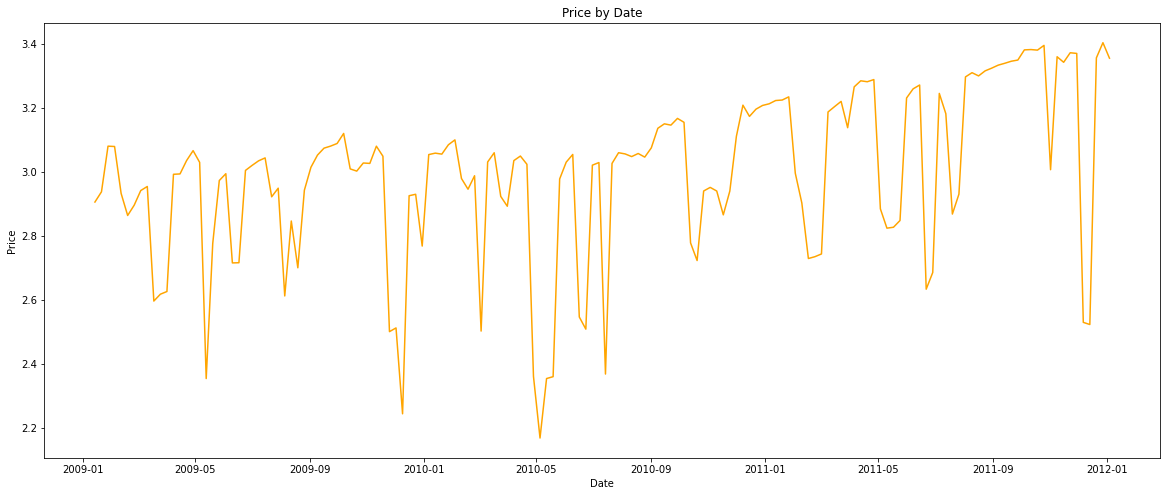

In [109]:
plt.rcParams["figure.figsize"] = [20,8]
plot_price = sns.lineplot(data=cereal_Kellogg, x="WEEK_END_DATE", y="PRICE", ci = None, color = 'orange')
plt.title("Price by Date")
plt.ylabel("Price")
plt.xlabel("Date")

### Price vs Base Price

Text(0.5, 1.0, 'Base Price')

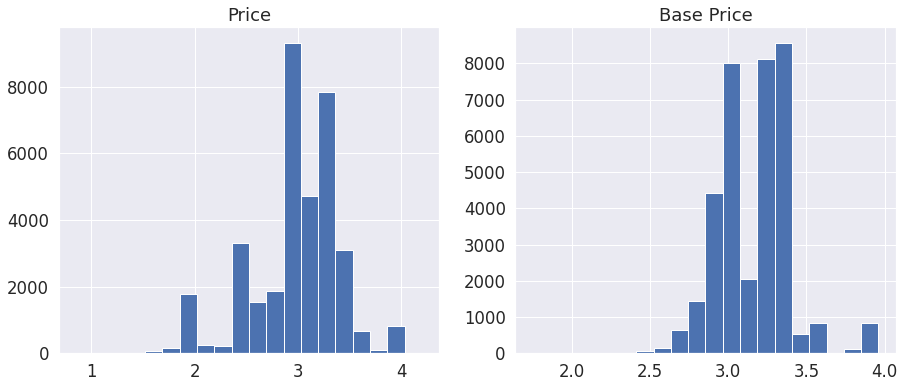

In [135]:
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,6))
sns.set(font_scale=1.5)
cereal_Kellogg.PRICE.hist(bins=20,ax=ax1) 
ax1.set_title('Price')
cereal_Kellogg.BASE_PRICE.hist(bins=20, ax=ax2) 
ax2.set_title('Base Price')

In [117]:
## 56.04% correlated
cereal_Kellogg[['PRICE','BASE_PRICE']].corr()

,PRICE,BASE_PRICE
PRICE,1.00000,0.56038
BASE_PRICE,0.56038,1.00000


In [360]:
cereal_Kellogg[['PRICE','UNITS']].corr()

,PRICE,UNITS
PRICE,1.000000,-0.555772
UNITS,-0.555772,1.000000


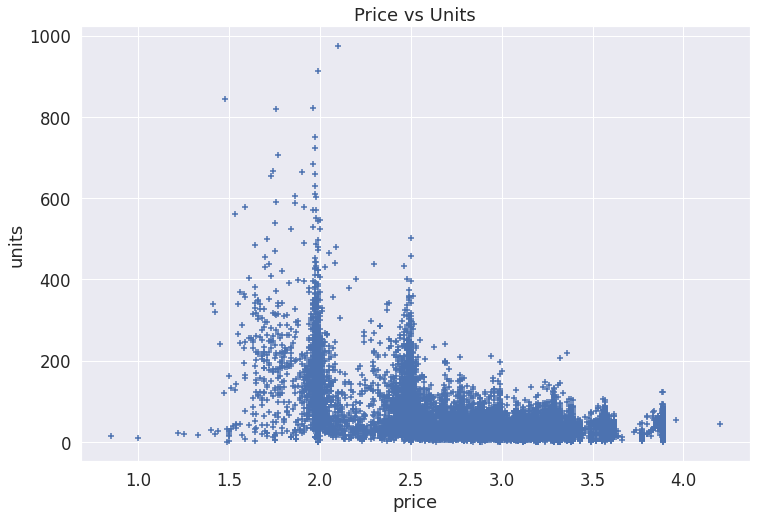

In [359]:
fig=plt.figure(figsize=(12,8))
sns.set(font_scale=1.5)
plt.scatter(cereal_Kellogg.PRICE, cereal_Kellogg.UNITS,marker='+')
plt.xlabel('price')
plt.ylabel('units')
plt.title('Price vs Units')
plt.show()

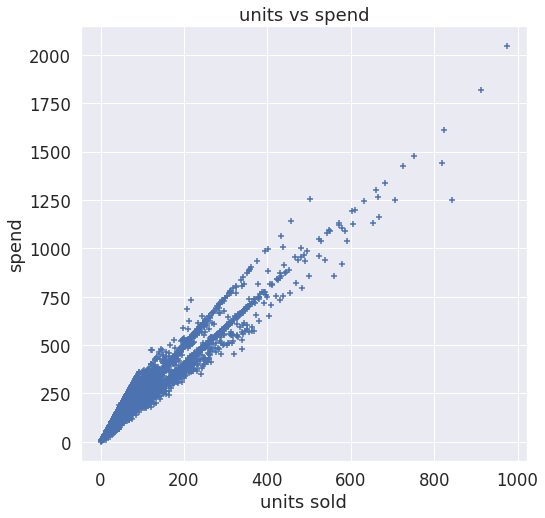

In [137]:
fig=plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
plt.scatter(cereal_Kellogg.UNITS, cereal_Kellogg.SPEND,marker='+')
plt.xlabel('units sold')
plt.ylabel('spend')
plt.title('units vs spend')
plt.show()

---

### UPC = 3800031829 (Family Cereal)

In [155]:
cereal_Kellogg.groupby("SUB_CATEGORY")[["BASE_PRICE", "PRICE"]].mean()

,BASE_PRICE,PRICE
SUB_CATEGORY,,
ALL FAMILY CEREAL,3.273618,3.164362
KIDS CEREAL,3.094547,2.908529


In [156]:
cereal_Kellogg.groupby("UPC")[["BASE_PRICE", "PRICE"]].mean()

,BASE_PRICE,PRICE
UPC,,
3800031829,3.273618,3.164362
3800031838,3.044505,2.886601
3800039118,3.144723,2.930515


In [219]:
cereal_Kellogg.groupby("UPC")["SPEND"].sum()

UPC
3800031829    1216282.24
3800031838    1483799.52
3800039118    1151163.13
Name: SPEND, dtype: float64

In [342]:
cereal_Kellogg_p1 = cereal_Kellogg[cereal_Kellogg.UPC == 3800031829]
cereal_Kellogg_p1.set_index('WEEK_END_DATE',inplace=True)
cereal_Kellogg_p1 = cereal_Kellogg_p1[cereal_Kellogg_p1.columns[cereal_Kellogg_p1.nunique()!=1]]
cereal_Kellogg_p1.nunique()

STORE_NUM                    77
UNITS                       218
VISITS                      179
HHS                         172
SPEND                      2883
PRICE                       185
BASE_PRICE                  117
FEATURE                       2
DISPLAY                       2
TPR_ONLY                      2
STORE_ID                     77
STORE_NAME                   73
ADDRESS_CITY_NAME            51
ADDRESS_STATE_PROV_CODE       4
MSA_CODE                      9
SEG_VALUE_NAME                3
PARKING_SPACE_QTY            24
SALES_AREA_SIZE_NUM          73
AVG_WEEKLY_BASKETS           77
MONTH                        12
YEAR                          4
UNITS/VISITS                916
VISITS/HHS                  742
dtype: int64

Text(0, 0.5, 'units sold')

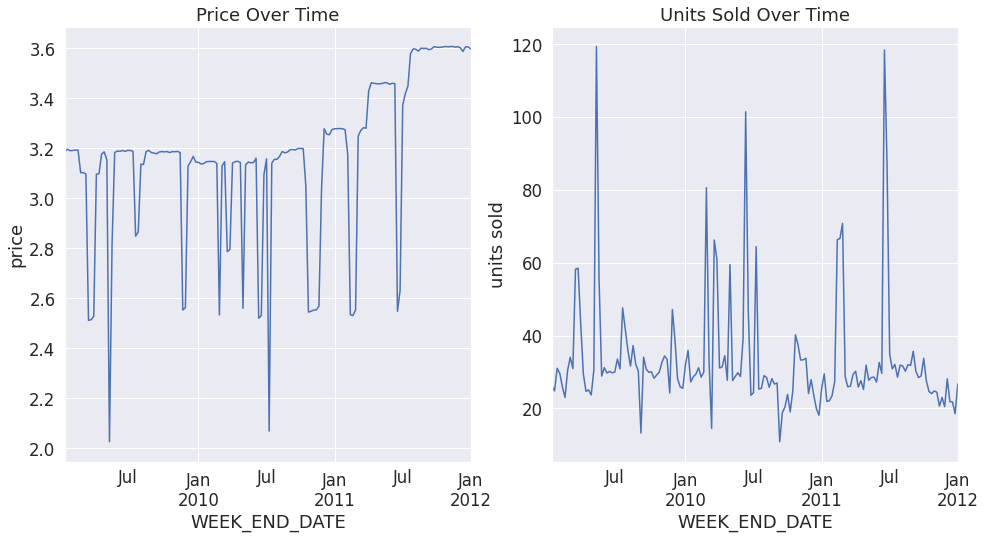

In [343]:
## In both graphs of historical price and units sold we can observe seasonality
## More sales from Spring to Summer. 
f, ax=plt.subplots(1, 2, figsize=(16,8))
sns.set(font_scale=1.5)
cereal_Kellogg_p1.groupby('WEEK_END_DATE')['PRICE'].mean().plot(ax=ax[0])
ax[0].set_title('Price Over Time')
ax[0].set_ylabel('price')
cereal_Kellogg_p1.groupby('WEEK_END_DATE')['UNITS'].mean().plot(ax=ax[1])
ax[1].set_title('Units Sold Over Time')
ax[1].set_ylabel('units sold')

Text(0, 0.5, 'units')

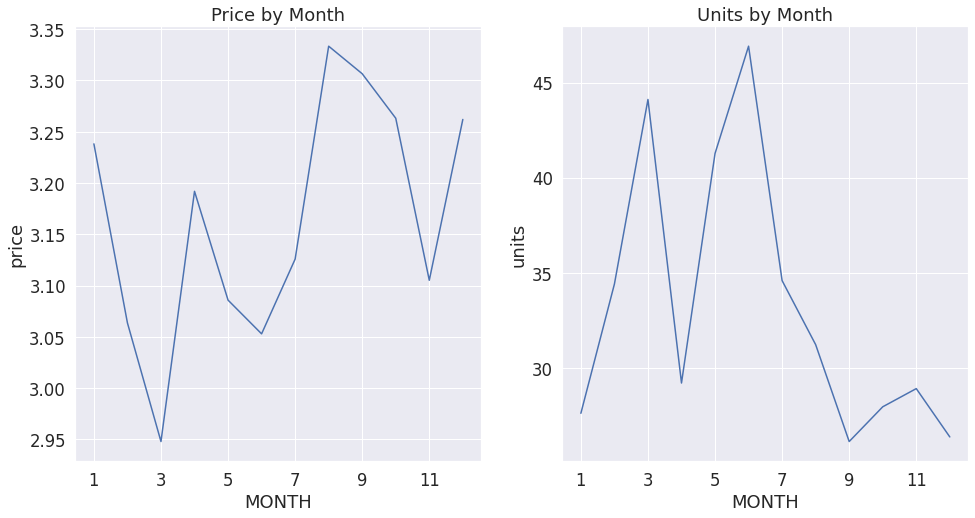

In [362]:
## In both graphs of historical price and units sold we can observe seasonality
## More sales from Spring to Summer. 
f, ax=plt.subplots(1, 2, figsize=(16,8))
sns.set(font_scale=1.5)
cereal_Kellogg_p1.groupby('MONTH')['PRICE'].mean().plot(ax=ax[0])
ax[0].set_title('Price by Month')
ax[0].set_ylabel('price')
cereal_Kellogg_p1.groupby('MONTH')['UNITS'].mean().plot(ax=ax[1])
ax[1].set_title('Units by Month')
ax[1].set_ylabel('units')

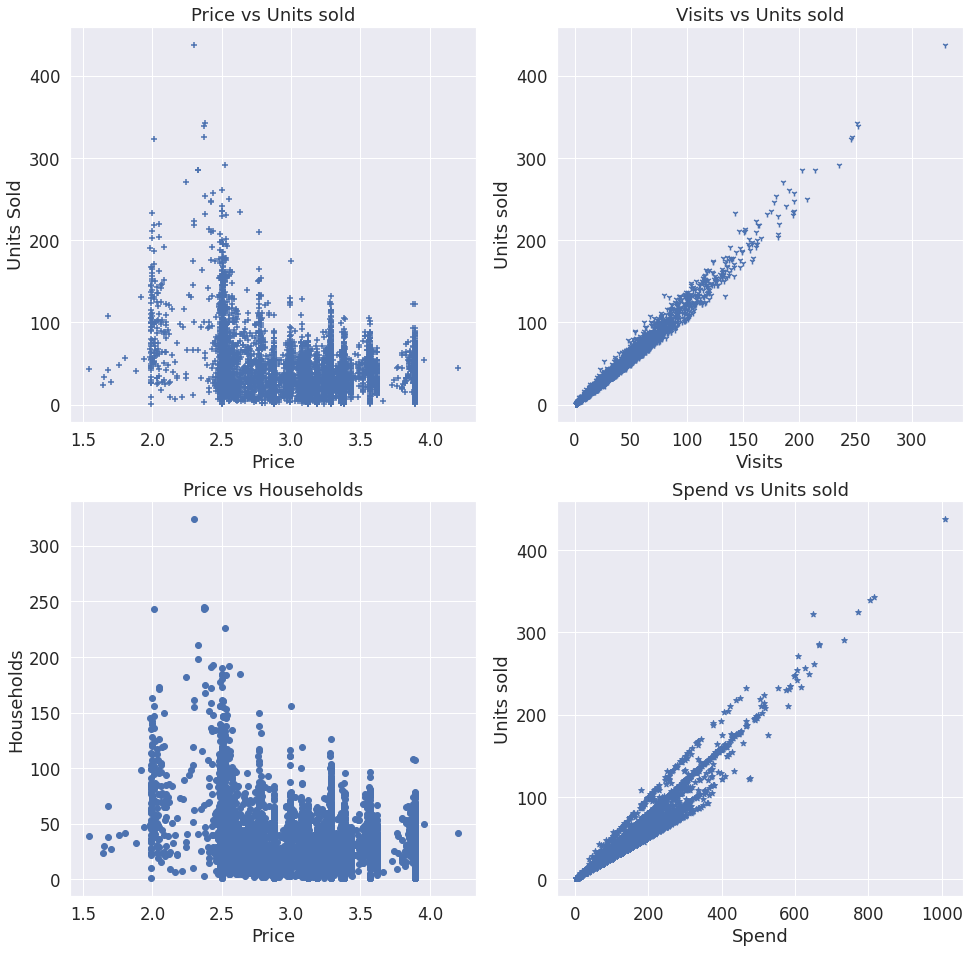

In [345]:
f, ax = plt.subplots(2,2,figsize=(16,16))
sns.set(font_scale=1.5)
# plt.xlim(1,2)
ax[0,0].scatter(cereal_Kellogg_p1.PRICE, cereal_Kellogg_p1.UNITS, marker='+')
ax[0,0].set_xlabel('price')
ax[0,0].set_ylabel('units Sold')
ax[0,0].set_title('Price vs Units sold')

ax[0,1].scatter(cereal_Kellogg_p1.VISITS, cereal_Kellogg_p1.UNITS, marker='1')
ax[0,1].set_xlabel('Visits')
ax[0,1].set_ylabel('Units Sold')
ax[0,1].set_title('Visits vs Units sold')

ax[1,0].scatter(cereal_Kellogg_p1.PRICE, cereal_Kellogg_p1.HHS, marker='o')
ax[1,0].set_xlabel('Price')
ax[1,0].set_ylabel('Households')
ax[1,0].set_title('Price vs Households')

ax[1,1].scatter(cereal_Kellogg_p1.SPEND, cereal_Kellogg_p1.UNITS, marker='*')
ax[1,1].set_xlabel('Spend')
ax[1,1].set_ylabel('Units sold')
ax[1,1].set_title('Spend vs Units sold')

plt.show()